In [1]:
import torch
import torch.nn as nn
import os
import imageio
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import time

The **generator** architecture in *Pix2Pix* uses a *U-Net* structure. *U-Net* has in a *encoder-decoder* network famous by its *skip connections* that help preserve fine details.

In [2]:
class UNetEncoder(nn.Module):
    def __init__(self, in_channels=3, num_features=64):
        super(UNetEncoder, self).__init__()
        # This module lets PyTorch recognize and manage the layers correctly during training.
        self.layers = nn.ModuleList()
        
        # Each step in the encoder halves the spatial dimensions of the input. 
        # Due to this downsampling, we can increase the number of filters learned by the model at each step. 
        # This is why the number of features is doubled at each step.

        # Batch normalization is not used in the first layer of the encoder. Applying BatchNorm immediately after
        # the first convolution could distort the input distribution, making training unstable.
        self.layers.append(self._create_down_block(in_channels, num_features, batch_norm=False)) # 256x256x3 -> 128x128x64

        self.layers.append(self._create_down_block(num_features, num_features*2)) # 128x128x64 -> 64x64x128
        self.layers.append(self._create_down_block(num_features*2, num_features*4)) # 64x64x128 -> 32x32x256
        self.layers.append(self._create_down_block(num_features*4, num_features*8)) # 32x32x256 -> 16x16x512

        for _ in range(3):
            self.layers.append(self._create_down_block(num_features*8, num_features*8)) 
        # The output shape after these 3 blocks is 2x2x512.

        # In deeper layers, feature maps become low-resolution. When this happens, we have a limited statistical diversity, 
        # leading to poor mean/variance estimates. Because of that, we avoid the use o batch normalization.
        # Dropout randomly drops a fraction of neurons during training to prevent over-reliance on certain features.
        self.layers.append(self._create_down_block(num_features*8, num_features*8, dropout=0.5, batch_norm=False)) # 2x2x512 -> 1x1x512
    
    # The down block consists of a convolutional layer, followed by batch normalization, Leaky ReLU activation, and dropout.
    def _create_down_block(self, input_channels, out_channels, batch_norm=True, dropout=0.0):
        return nn.Sequential(
            # The stride of 2 halves the spatial dimensions of the input. Also, padding is used to maintain the spatial dimensions.
            nn.Conv2d(input_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity(),
            # We use Leaky ReLU activation function to avoid the dying ReLU problem.
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout) if dropout > 0 else nn.Identity(),
        )
    
    # The forward method iterates over the layers and applies them sequentially. 
    def forward(self, x):
        # During the forward pass, we store the feature maps of each layer in the skips list.
        # This list is used in the decoder to concatenate the feature maps of the encoder with the feature maps of the decoder.
        skips = []
        for layer in self.layers[:-1]:
            x = layer(x)
            skips.append(x)

        # The bottleneck of the encoder does not have a skip connection.
        x = self.layers[-1](x)
        return x, skips
    

# The decoder is the second half of the U-Net architecture. It consists of up-sampling blocks to reconstruct the image
# from the extracted features.
class UNetDecoder(nn.Module):
    def __init__(self, out_channels=3, num_features=64):
        super(UNetDecoder, self).__init__()
        self.layers = nn.ModuleList()
        
        # The first block receives only the output of the encoder. There is no skip connection here yet.
        # This layer also uses dropout to prevent overfitting.
        self.layers.append(self._create_up_block(num_features*8, num_features*8, dropout=0.5)) # 1x1x512 -> 2x2x512

        # Here we start concatenating the feature maps of the encoder with the output of the previous layer. Because
        # of this, the number of input channels is doubled.
        for _ in range(2):
            self.layers.append(self._create_up_block(num_features*16, num_features*8, dropout=0.5)) # 2x2x1024 -> 4x4x512
                                                                                                    # 4x4x1024 -> 8x8x512
        
        # The following blocks are similar to the previous ones, but the number of input channels is halved at each step. 
        # Also, we don't use dropout since the resolution is higher, thus less propense to overfitting.
        self.layers.append(self._create_up_block(num_features*16, num_features*8)) # 8x8x1024 -> 16x16x512
        self.layers.append(self._create_up_block(num_features*16, num_features*4)) # 16x16x1024 -> 32x32x256
        self.layers.append(self._create_up_block(num_features*8, num_features*2)) # 32x32x512 -> 64x64x128
        self.layers.append(self._create_up_block(num_features*4, num_features)) # 64x64x256 -> 128x128x64

        # The last layer of the decoder is a convolutional layer that reduces the number of channels to the desired output.
        # Batch normalization is disabled to avoid distorting the output distribution.
        self.layers.append(nn.ConvTranspose2d(num_features*2, out_channels, kernel_size=4, stride=2, padding=1)) # 128x128x128 -> 256x256x3

    # The up block consists of a transposed convolutional layer, followed by batch normalization, ReLU activation, and dropout.
    # This block recover the spatial dimensions of the input.
    def _create_up_block(self, input_channels, out_channels, batch_norm=True, dropout=0.0):
        return nn.Sequential(
            nn.ConvTranspose2d(input_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=not batch_norm),
            nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.Dropout(dropout) if dropout else nn.Identity(),
        )
    
    def forward(self, x, skips):
        skips = list(reversed(skips))
        x = self.layers[0](x) # The first layer processes only the bottleneck output.

        # The following layers concatenate the feature maps of the encoder with the feature maps
        # of the decoder through the skip connections.
        for i, layer in enumerate(self.layers[1:]):
            x = torch.cat((x, skips[i]), dim=1)
            x = layer(x)
        return x


class Generator(nn.Module):
    def __init__(self, in_channels, out_channels, num_features=64):
        super(Generator, self).__init__()

        # THe generator is simply the encoder and decoder combined.
        # In total, we have 8 down blocks and 8 up blocks.
        self.encoder = UNetEncoder(in_channels, num_features)
        self.decoder = UNetDecoder(out_channels, num_features)
    
    # The forward method of the generator first passes the input through the encoder.
    # The output of the encoder and the skip connections are then passed to the decoder.
    def forward(self, x):
        x, skips = self.encoder(x)
        x = self.decoder(x, skips)
        x = torch.tanh(x) # Normalize to [-1, 1]
        return x

The **discriminator** uses a *PatchGAN* architecture to classify image patches.

In [3]:
# In Pix2Pix, the discriminator is a PatchGAN, which means it classifies overlapping patches of the image as real or fake. 
class Discriminator(nn.Module):
    def __init__(self, in_channels, num_features=64):
        super(Discriminator, self).__init__()

        # The discriminator uses a series of convolutional layers with increasing filters, reducing spatial dimensions each time.
        # The final layer outputs a matrix where each element corresponds to a patch of the input image.
        self.model = nn.Sequential(
            # Considering a 256x256 image, the first layer outputs a 128x128 matrix.
            self._create_block(in_channels*2, num_features, stride=2, batch_norm=False), # 256x256x6 -> 128x128x64
            self._create_block(num_features, num_features*2, stride=2), # 128x128x64 -> 64x64x128
            self._create_block(num_features*2, num_features*4, stride=2), # 64x64x128 -> 32x32x256
            self._create_block(num_features*4, num_features*8, stride=1), # 32x32x256 -> 31x31x512
            nn.Conv2d(num_features*8, 1, kernel_size=4, stride=1, padding=1), # 31x31x512 -> 30x30x1
        )
        
    def _create_block(self, in_channels, out_channels, stride, batch_norm=True):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity(),
            nn.LeakyReLU(0.2, True),
        )

    # in the Pix2Pix GAN, the discriminator receives the input image and the target image as input.
    # Because of that, it is called a conditional GAN, because the discriminator is conditioned on the target image.
    def forward(self, x, y):
        # The input image and the target image are concatenated along the channel dimension.
        return self.model(torch.cat([x, y], dim=1))
    

C:\Users\dti Digital\AppData\Local\Temp\ipykernel_35920\1488753455.py:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  A_img = imageio.imread(A_path)
C:\Users\dti Digital\AppData\Local\Temp\ipykernel_35920\1488753455.py:39: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  B_img = imageio.imread(B_path)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


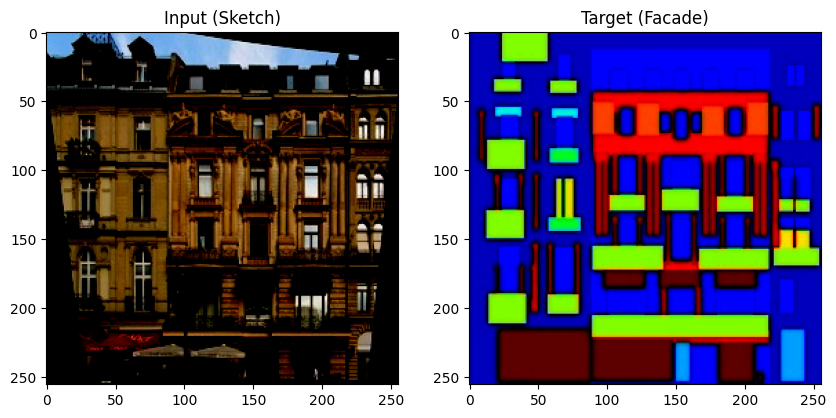

In [4]:
# Transformations for the images (normalize to [-1, 1])
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),  # Resize if needed
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

class FacadesDataset(Dataset):
    def __init__(self, root_dir, mode='train', transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode
        
        # Based on the mode (train or test), choose the directories
        self.train_A = os.listdir(os.path.join(root_dir, 'train/A'))
        self.train_B = os.listdir(os.path.join(root_dir, 'train/B'))

        if self.mode == 'train':
            self.data_A = self.train_A
            self.data_B = self.train_B
        elif self.mode == 'test':
            self.test_A = os.listdir(os.path.join(root_dir, 'test/A'))
            self.test_B = os.listdir(os.path.join(root_dir, 'test/B'))
            self.data_A = self.test_A
            self.data_B = self.test_B
        else:
            raise ValueError("Mode should be either 'train' or 'test'")

    def __len__(self):
        return len(self.data_A)

    def __getitem__(self, idx):
        # Load the input and target images
        A_path = os.path.join(self.root_dir, 'train/A' if self.mode == 'train' else 'test/A', self.data_A[idx])
        B_path = os.path.join(self.root_dir, 'train/B' if self.mode == 'train' else 'test/B', self.data_B[idx])
        
        A_img = imageio.imread(A_path)
        B_img = imageio.imread(B_path)

        if self.transform:
            A_img = self.transform(A_img)
            B_img = self.transform(B_img)

        return A_img, B_img


# Defining the root directory of the facades dataset
root_dir = './facades/facades/'  # Adjust the path as needed

# Create the dataset for training and testing
train_dataset = FacadesDataset(root_dir=root_dir, mode='train', transform=transform)
test_dataset = FacadesDataset(root_dir=root_dir, mode='test', transform=transform)

# Create data loaders for train and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Example of visualizing loaded images
data_iter = iter(train_loader)
images_A, images_B = next(data_iter)

# Visualize the first image pair (input and target)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(images_A[0].cpu().numpy().transpose(1, 2, 0))
plt.title('Input (Sketch)')
plt.subplot(1, 2, 2)
plt.imshow(images_B[0].cpu().numpy().transpose(1, 2, 0))
plt.title('Target (Facade)')
plt.show()

In [5]:
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation

train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=8, shuffle=False)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = Generator(3, 3).to(device)
discriminator = Discriminator(3).to(device)

# Loss functions.

# Adversarial loss (Binary Cross-Entropy loss).
adv_criterion = nn.BCEWithLogitsLoss()
# L1 loss (for generator to preserve structure).
l1_criterion = nn.L1Loss()

# Optimizers.

lr = 0.0002
beta1 = 0.5
beta2 = 0.999

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

lambda_l1 = 100

In [ ]:

# Hyperparameters
num_epochs = 100
lambda_l1 = 100  # Weight for L1 loss in generator total loss
print_interval = 20  # Save sample images every N epochs

# Track training statistics
best_g_loss = float('inf')  # Track best generator loss for checkpointing

# Start training timer
total_start_time = time.time()

for epoch in range(num_epochs):
    # Initialize epoch timers and counters
    epoch_start_time = time.time()
    epoch_d_loss = 0.0
    epoch_g_adv_loss = 0.0
    epoch_g_l1_loss = 0.0
    num_batches = len(train_loader)
    
    # Set models to training mode
    generator.train()
    discriminator.train()

    for batch_idx, (real_A, real_B) in enumerate(train_loader):
        # Move data to target device (GPU/CPU)
        real_A = real_A.to(device)
        real_B = real_B.to(device)
        batch_size = real_A.size(0)  # Current batch size (last batch might be smaller)

        # ========================
        #  Train Discriminator
        # ========================
        # Discriminator learns to distinguish real vs generated pairs
        
        # Zero-out existing gradients
        optimizer_D.zero_grad()

        # Forward pass real samples through discriminator
        with torch.no_grad():
            fake_B = generator(real_A)  # Detached in next step
        
        # Create mixed batch of real and fake pairs
        D_real = discriminator(real_A, real_B)  # Real pairs
        D_fake = discriminator(real_A, fake_B.detach())  # Fake pairs (detach to avoid training G here)

        # Calculate discriminator loss components
        real_loss = adv_criterion(D_real, torch.ones_like(D_real))  # Real pairs should be labeled 1
        fake_loss = adv_criterion(D_fake, torch.zeros_like(D_fake))  # Fake pairs should be labeled 0
        D_loss = (real_loss + fake_loss) * 0.5  # Average real and fake losses

        # Backpropagate and update discriminator
        D_loss.backward()
        optimizer_D.step()

        # ========================
        #  Train Generator
        # ========================
        # Generator learns to fool discriminator while matching real images
        
        # Zero-out existing gradients
        optimizer_G.zero_grad()

        # Forward pass fake samples through updated discriminator
        fake_B = generator(real_A)
        D_fake = discriminator(real_A, fake_B)

        # Calculate generator losses
        G_adv_loss = adv_criterion(D_fake, torch.ones_like(D_fake))  # Try to fool D into thinking fakes are real
        G_l1_loss = l1_criterion(fake_B, real_B) * lambda_l1  # Pixel-wise similarity
        G_loss = G_adv_loss + G_l1_loss  # Total generator loss

        # Backpropagate and update generator
        G_loss.backward()
        optimizer_G.step()

        # ========================
        #  Progress Tracking
        # ========================
        # Accumulate epoch statistics
        epoch_d_loss += D_loss.item() * batch_size
        epoch_g_adv_loss += G_adv_loss.item() * batch_size
        epoch_g_l1_loss += G_l1_loss.item() * batch_size

    # ========================
    #  Epoch Finalization
    # ========================
    # Calculate epoch averages
    epoch_d_loss /= len(train_loader.dataset)
    epoch_g_adv_loss /= len(train_loader.dataset)
    epoch_g_l1_loss /= len(train_loader.dataset)
    epoch_g_total_loss = epoch_g_adv_loss + epoch_g_l1_loss

    # Calculate epoch duration
    epoch_time = time.time() - epoch_start_time
    total_time = time.time() - total_start_time

    # Print epoch statistics
    print(f'\n[Epoch {epoch+1}/{num_epochs}] '
          f'Time: {epoch_time:.1f}s ({total_time//3600:.0f}h {total_time%3600//60:.0f}m total)')
    print(f'D_loss: {epoch_d_loss:.4f} '
          f'G_loss: {epoch_g_total_loss:.4f} '
          f'(Adv: {epoch_g_adv_loss:.4f}, L1: {epoch_g_l1_loss:.4f})')

    # # Save periodic samples and checkpoints
    # if (epoch+1) % print_interval == 0 or epoch == 0:
    #     # Save sample images
    #     with torch.no_grad():
    #         sample_fake = generator(real_A[:1])  # Get first sample from last batch
    #         img_grid = torch.cat([real_A[:1], real_B[:1], sample_fake], -1)
    #         save_image(img_grid, f"samples/epoch_{epoch+1}.png", normalize=True)
            
    #     # Save model checkpoints
    #     if epoch_g_total_loss < best_g_loss:
    #         best_g_loss = epoch_g_total_loss
    #         torch.save(generator.state_dict(), f'checkpoints/generator_best.pth')
    #         torch.save(discriminator.state_dict(), f'checkpoints/discriminator_best.pth')

# Final training summary
print(f'\nTraining completed in {total_time//3600:.0f}h {total_time%3600//60:.0f}m')
print(f'Best Generator Loss: {best_g_loss:.4f}')

C:\Users\dti Digital\AppData\Local\Temp\ipykernel_35920\1488753455.py:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  A_img = imageio.imread(A_path)
C:\Users\dti Digital\AppData\Local\Temp\ipykernel_35920\1488753455.py:39: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  B_img = imageio.imread(B_path)



[Epoch 1/100] Time: 185.9s (0h 3m total)
D_loss: 0.2521 G_loss: 44.2189 (Adv: 2.6705, L1: 41.5484)
